### CVRP model_ortools方法
#### 运行没有问题，但是距离矩阵即调用数据是大问题（600个点且含已定路径）<p>若要用此model可以设定没有连接的路径距离为inf，遍历excel数据计算得矩阵

In [1]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
 
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,468, 776, 662],
        [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,1016, 868, 1210],
        [ 776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,1130, 788, 1552, 754],
        [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,1164, 560, 1358],
        [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,1050, 674, 1244],
        [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,514, 1050, 708],
        [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,514, 1278, 480],
        [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,662, 742, 856],
        [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,320, 1084, 514],
        [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,274, 810, 468],
        [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,730, 388, 1152, 354],
        [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,308, 650, 274, 844],
        [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,536, 388, 730],
        [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,342, 422, 536],
        [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,342, 0, 764, 194],
        [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,388, 422, 764, 0, 798],
        [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,536, 194, 798, 0],
    ]#距离矩阵 这些地点其实是位于地图上的地点，为了简单化我们将这些地点放到了一个矩形表格中这样处理更加直观
    #一些便于理解， 然后我们会通过一些第三方的地图接口(百度、高德)去计算每个需要访问的地点它们两两之间的
    # 实际距离，并得到一个距离矩阵(distance_matrix)。
    #计算详见：https://developers.google.com/optimization/routing/vrp
    data['num_vehicles'] = 4 #车辆数量
    data['depot'] = 0 #出发点索引
    data['demands'] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8] #每个地点的需求量
    data['vehicle_capacities'] = [15, 15, 15, 15]#每辆车的容量
    return data
 
data = create_data_model()
type(data['distance_matrix'])

list

In [ ]:
 
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),data['num_vehicles'], data['depot']) 
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
 
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

def demand_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]
    
 
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index, # callback_index
    0,  # slack_max
    data['vehicle_capacities'],  # capacity
    True,  # fix_start_cumulative_to_zero
    'Capacity') #维度名称

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
 #注意: 使用 GUIDED_LOCAL_SEARCH 或其他元启发式算法时，需要为求解器设置搜索时间限制——否则求解器不会终止。 可以将时间限制设置为 30 秒。
search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(30)

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

In [ ]:
solution = routing.SolveWithParameters(search_parameters)
 
if solution:
    print_solution(data, manager, routing, solution)

Objective: 6208
Route for vehicle 0:
 0 Load(0) ->  4 Load(4) ->  3 Load(6) ->  1 Load(7) ->  7 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  14 Load(4) ->  16 Load(12) ->  10 Load(14) ->  9 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 2:
 0 Load(0) ->  12 Load(2) ->  11 Load(3) ->  15 Load(11) ->  13 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 3:
 0 Load(0) ->  8 Load(8) ->  2 Load(9) ->  6 Load(13) ->  5 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Total distance of all routes: 6208m
Total load of all routes: 60


## ortools_CVRP

In [3]:
## 导入库函数
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import tsplib95
import matplotlib.pyplot as plt
%matplotlib inline

### 数据准备：<p>1、直接修改dic内容，以id为字典指标；(参考：[https://blog.csdn.net/kittyzc/article/details/84314956]\\[https://blog.csdn.net/weixin_42608414/article/details/120917912])<p>2、多个二维数组转换为距离矩阵；（建议scipy求解：[https://zhuanlan.zhihu.com/p/77034615]\\[https://en.wikipedia.org/wiki/Taxicab_geometry]）

In [ ]:
#demand_a
import pandas as pd
def excel_one_line_to_list():
    df = pd.read_excel(r'/home/jesse_chen/anaconda3/A_computer_science/数维B题/Annex1：node＆link.xlsx',sheet_name='demand_a')  # 读取项目名称列,不要列名
    df_li = df.values.tolist()
    result = []
    for s_li in df_li:
        result.append(s_li[0])
    return result
demand_a=excel_one_line_to_list()

[3853, 3786, 142073, 358568, 354, 454, 1654, 669, 622, 3463, 184880, 43568, 336, 15958, 25883, 427292, 220301, 219561, 184936, 26284, 24925, 219801, 141550, 4195, 3364, 3528, 26021, 771209, 840565, 942916, 185025, 771538, 142261, 3519, 3038, 26501, 840477, 5385, 771631, 2916, 2798, 929, 425, 314579, 141661, 1199, 4910, 61087, 2373, 1591, 917, 53, 0, 903, 53, 141893, 1659, 0, 0, 27, 46, 114477, 3582, 3705, 26140, 15584, 62555, 141931, 5936, 14884, 25170, 26024, 62606, 454, 599, 258, 303, 3741, 219412, 220013, 840661, 840669, 617284, 1751, 4281, 1117, 25599, 185014, 141895, 5626, 4491, 346, 14516, 14753, 43704, 61196, 142079, 115159, 24827, 2, 184845, 4378, 3102, 1419, 1754, 2099, 3092, 3784, 4521, 15833, 4561, 9, 1264, 3145, 61011, 3242, 289, 3, 5279, 700, 3301, 2100, 1037, 992, 15679, 2016, 4787, 220189, 4213, 115612, 184827, 52, 3297, 2896, 2209, 1043, 449, 296, 1, 823, 758, 1145, 1943, 20, 468, 81, 220540, 25568, 25552, 25197, 2981, 629, 0, 508, 606, 2084, 2257, 2986, 1181, 957, 878,

In [6]:
# 给定数据目录并读入数据
fname: str = "gr120.tsp"
input_fpath: str = r"/home/jesse_chen/anaconda3/A_computer_science/数维B题/" + fname
data = tsplib95.load(input_fpath).as_name_dict()

# 让节点编号从0开始
data["display_data"] = {k-1: v for k, v in data["display_data"].items()}
# 补充每个节点的demand数据
rng = np.random.default_rng(seed = 0)
data["demand"] = rng.integers(1, 11, data["dimension"]) # 随机生成[1, 10]的需求
# 车辆数据
n_vehicles = 4 # 车辆数
capacity = [250] * n_vehicles # 车辆最大负载
vehicle_start_idx = rng.integers(0, data["dimension"], n_vehicles) # 每辆车的起点
# 注意ortools是c++写的，它并不接受 np.int64，因此要转化为python原生的int类型
vehicle_start_idx = [i.item() for i in vehicle_start_idx]
vehicle_end_idx = rng.integers(0, data["dimension"], n_vehicles) # 每辆车的终点
vehicle_end_idx = [i.item() for i in vehicle_end_idx]

{0: [8.0, 124.0], 1: [125.0, 80.0], 2: [97.0, 74.0], 3: [69.0, 96.0], 4: [106.0, 46.0], 5: [49.0, 57.0], 6: [80.0, 125.0], 7: [42.0, 93.0], 8: [104.0, 94.0], 9: [35.0, 17.0], 10: [118.0, 96.0], 11: [151.0, 22.0], 12: [154.0, 182.0], 13: [57.0, 165.0], 14: [18.0, 159.0], 15: [27.0, 123.0], 16: [96.0, 170.0], 17: [63.0, 198.0], 18: [59.0, 211.0], 19: [88.0, 182.0], 20: [142.0, 72.0], 21: [48.0, 190.0], 22: [106.0, 106.0], 23: [28.0, 102.0], 24: [63.0, 224.0], 25: [58.0, 93.0], 26: [103.0, 56.0], 27: [38.0, 149.0], 28: [23.0, 138.0], 29: [22.0, 146.0], 30: [32.0, 208.0], 31: [27.0, 144.0], 32: [75.0, 258.0], 33: [59.0, 101.0], 34: [41.0, 32.0], 35: [53.0, 46.0], 36: [76.0, 19.0], 37: [79.0, 115.0], 38: [109.0, 13.0], 39: [59.0, 118.0], 40: [84.0, 147.0], 41: [95.0, 160.0], 42: [87.0, 213.0], 43: [73.0, 166.0], 44: [43.0, 153.0], 45: [81.0, 175.0], 46: [59.0, 77.0], 47: [70.0, 68.0], 48: [106.0, 169.0], 49: [86.0, 168.0], 50: [127.0, 109.0], 51: [68.0, 243.0], 52: [116.0, 57.0], 53: [39.0,

#### 节点可视化

Text(0.5, 1.0, 'gr120.tsp Nodes')

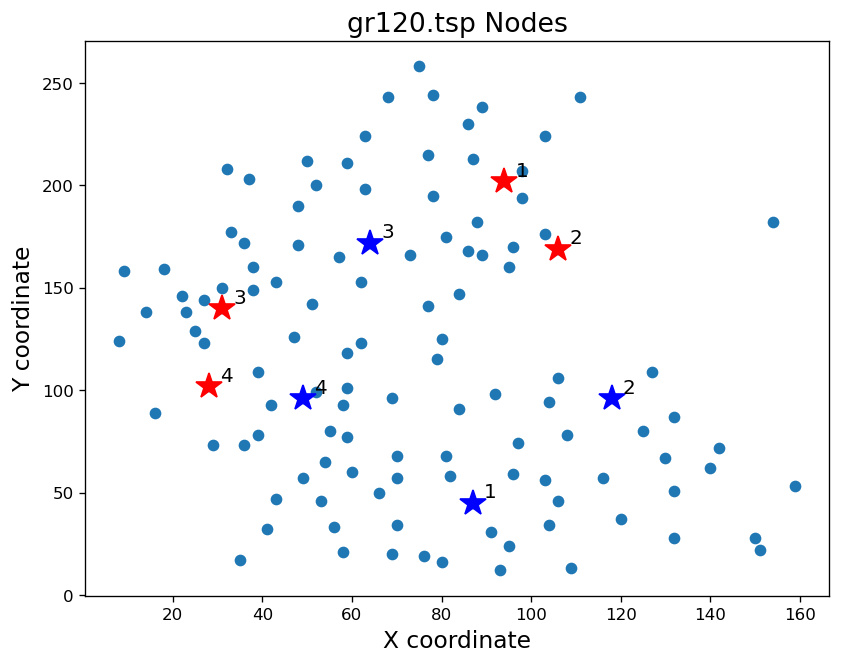

In [3]:
x_coor: list = [i[0] for i in data['display_data'].values()]
y_coor: list = [i[1] for i in data['display_data'].values()]
plt.figure(figsize = (8, 6), dpi = 120)
plt.scatter(x_coor, y_coor)
idx = 1
offset = 2.5
for start, end in zip(vehicle_start_idx, vehicle_end_idx):
    plt.plot(data["display_data"][start][0], data["display_data"][start][1], "r*", markersize=16)
    plt.plot(data["display_data"][end][0], data["display_data"][end][1], "b*", markersize=16)
    plt.text(data["display_data"][start][0]+offset, data["display_data"][start][1]+offset, "{}".format(idx),fontsize=12)
    plt.text(data["display_data"][end][0]+offset, data["display_data"][end][1]+offset, "{}".format(idx),fontsize=12)
    idx += 1
plt.xlabel("X coordinate", fontsize = 14)
plt.ylabel("Y coordinate", fontsize = 14)
plt.title("{} Nodes".format(fname), fontsize = 16)

#### 建立并求解CVRP问题<p>参考：[https://zhuanlan.zhihu.com/p/405467844] [https://developers.google.com/optimization/routing/cvrp]

In [11]:
# 建立RoutingIndexManager
manager = pywrapcp.RoutingIndexManager(data["dimension"], n_vehicles, 
                             vehicle_start_idx, vehicle_end_idx)
# 实例化RoutingModel
routing = pywrapcp.RoutingModel(manager)
# 建立一个callback来记录车辆的总行驶里程
def distance_callback(from_index: int, to_index: int):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    from_coor = data['display_data'][from_node]
    to_coor = data['display_data'][to_node]
    return (to_coor[0] - from_coor[0])**2 + (to_coor[1] - from_coor[1])**2

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# 给每条边设置cost
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
# 建立一个callback来记录车辆的负载
def demand_callback(from_index: int):
    # 经过一个节点之后，累加节点上的需求量-----------------------------------总流量
    from_node = manager.IndexToNode(from_index)
    return data['demand'][from_node]
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
## -------------------------------------------------------------------可附加约束：
    # 利用这个callback，施加capacity约束
routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # 不允许松弛
        capacity,  # 车辆的最大允许负载
        True,  # 从0开始进行累积
        'Capacity')
## 通过软约束来平衡车辆的负载,通过软约束在目标函数中添加惩罚项
    # 1\ 通过累加所有节点上的需求量，得到每辆车平均需要承担的负载（这里更精细一点的处理应该去除掉depot的需求量，
        # 因为通常定义上我们不需要服务车库）；统计每辆车路径上的负载，当车辆负载超过平均负载时，施加一个惩罚函数
    # 2\ RoutingModel.AddDisjunction(indices: List[int64], penalty = 0: int64, max_cardinality: int64 = 1)
        # 添加一个disjuction constraint，要求在传入的indices代表的节点中有max_cardinality个被访问到
        # （注意这里在indices中，我们不能传入车辆的起点和终点），如果没有足够数量的节点被访问，
        # 那么我们的惩罚为 p*penalty，其中p=max_cardinality - sum(active[i])这里要求传入的penalty为正数，
        # 否则将会强制这些节点不会被访问；它的一个变种应用是当我们有一些节点可选时，我们将每个节点的index传入，
        # 这样当我们drop掉这个节点时，我们会受到惩罚，但是不再强制每个节点都会被访问。
## 通过系数设置在目标函数中添加自定义项
    # RoutingDimension.SetGlobalSpanCostCoefficient(coefficient: int64) - 这里所谓的Global，
    # 指的是全局所有车辆中该累积量在终点的最大值和在起点的最小值之差，
    # 也就是global_span_cost = coefficient * (Max(dimension end value) - Min(dimension start value))；
    # 在限定车辆服务的节点数时，我们常用这种方法。它还有两个类似的方法:
    # SetSpanCostCoefficientForAllVehicles和SetSpanCostCoefficientForVehicle
## 通过设定边上/车辆上的代价改变目标函数
    # 1\ RoutingModel.SetArcCostEvaluatorOfAllVehicles(evaluator_index: int) - 为所有车辆设置
        # 访问arc时的代价。注意这里传入的参数是evaluator_index而非evaluate function，
        # 因此在准备好评价函数之后，还需要先进行一步register call back，获取index才能传入这个方法。
    # 2\ RoutingModel.SetArcCostEvaluatorOfVehicle(evaluator_index: int, vehicle: int) - 
        # 为单独的某辆车设置访问arc时的代价，这个方法在有driver-dependent cost时非常有用。
    # 3\ RoutingModel.SetFixedCostOfAllVehicles(cost: int64) - 很好理解的方法，
        # 为每辆车添加相同的固定成本。它还有个变种
        # RoutingModel.SetFixedCostOfVehicle(cost: int64, vehicle: int) 可以单独为每辆车设定固定成本。
demand_dimension = routing.GetDimensionOrDie('Capacity')
penalty_coef: int = 1000
average_demand: int = sum(data['demand']).item()//n_vehicles
for vehicle_id in range(manager.GetNumberOfVehicles()):
    index = routing.End(vehicle_id)
    demand_dimension.SetCumulVarSoftUpperBound(index, average_demand, penalty_coef)
# 设定求解参数
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(100) # 设置最大求解时间100秒

# 求解
solution = routing.SolveWithParameters(search_parameters)

# 输出结果
print(f'Objective: {solution.ObjectiveValue()}')
total_distance = 0
total_load = 0
paths = []
for vehicle_id in range(n_vehicles):
    index = routing.Start(vehicle_id)
    plan_output = '车辆 {} 的路径:\n'.format(vehicle_id)
    route_distance = 0
    route_load = 0
    path: list = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        path.append(node_index)
        route_load += data['demand'][node_index]
        plan_output += ' {0} 装载({1}) -> '.format(node_index, route_load)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(
            previous_index, index, vehicle_id)
    plan_output += ' {0} 装载({1})\n'.format(manager.IndexToNode(index),
                                             route_load)
    path.append(manager.IndexToNode(index))
    plan_output += '路径总长度: {}m\n'.format(route_distance)
    plan_output += '路径总负载: {}\n'.format(route_load)
    print(plan_output)
    paths.append(path)
    total_distance += route_distance
    total_load += route_load
print('所有路径总长度: {}m'.format(total_distance))
print('所有路径总负载: {}'.format(total_load))

Objective: 34879
车辆 0 的路径:
 68 装载(9) ->  42 装载(10) ->  107 装载(11) ->  18 装载(17) ->  84 装载(25) ->  65 装载(27) ->  30 装载(36) ->  116 装载(44) ->  24 装载(48) ->  51 装载(52) ->  32 装载(53) ->  99 装载(62) ->  78 装载(68) ->  57 装载(75) ->  90 装载(79) ->  67 装载(87) ->  64 装载(96) ->  112 装载(105) ->  97 装载(106) ->  43 装载(108) ->  13 装载(115) ->  86 装载(121) ->  73 装载(126) ->  104 装载(134) ->  39 装载(139) ->  33 装载(148) ->  46 装载(154) ->  47 装载(161) ->  100 装载(166) ->  113 装载(166)
路径总长度: 8110m
路径总负载: 166

车辆 1 的路径:
 48 装载(3) ->  12 装载(9) ->  117 装载(12) ->  41 装载(13) ->  40 装载(18) ->  55 装载(28) ->  6 装载(29) ->  3 装载(32) ->  70 装载(36) ->  53 装载(46) ->  95 装载(53) ->  89 装载(57) ->  54 装载(66) ->  88 装载(74) ->  5 装载(75) ->  83 装载(79) ->  35 装载(85) ->  103 装载(88) ->  34 装载(89) ->  9 装载(98) ->  98 装载(102) ->  61 装载(109) ->  36 装载(110) ->  66 装载(116) ->  82 装载(119) ->  38 装载(124) ->  56 装载(128) ->  4 装载(132) ->  26 装载(138) ->  52 装载(143) ->  63 装载(147) ->  92 装载(150) ->  114 装载(159) ->  50 装载(167) ->  10 装载(167)
路径总长度

#### 路径可视化

Text(0.5, 1.0, 'CVRP paths')

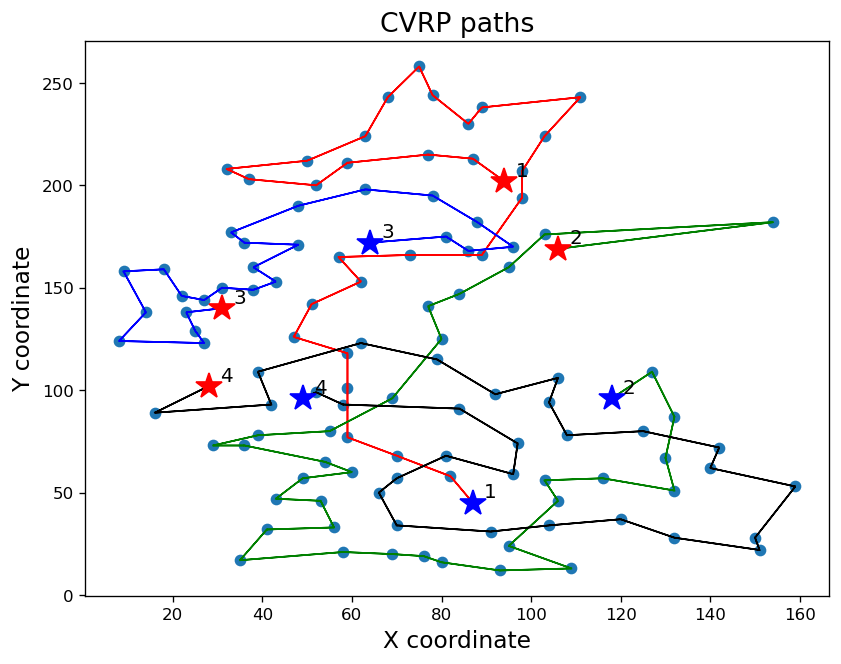

In [12]:
colors = ['r', 'g', 'b', 'k']
# 画出所有节点
x_coor: list = [i[0] for i in data['display_data'].values()]
y_coor: list = [i[1] for i in data['display_data'].values()]
plt.figure(figsize = (8, 6), dpi = 120)
plt.scatter(x_coor, y_coor)
# 画出每辆车的起点和终点
idx = 1
for start, end in zip(vehicle_start_idx, vehicle_end_idx):
    plt.plot(data["display_data"][start][0], data["display_data"][start][1], "r*", markersize=16)
    plt.plot(data["display_data"][end][0], data["display_data"][end][1], "b*", markersize=16)
    plt.text(data["display_data"][start][0]+offset, data["display_data"][start][1]+offset, "{}".format(idx),fontsize=12)
    plt.text(data["display_data"][end][0]+offset, data["display_data"][end][1]+offset, "{}".format(idx),fontsize=12)
    idx += 1
# 画出每辆车的路径
for k in range(n_vehicles):
    path = paths[k]
    for i, j in zip(path, path[1:]):
        start_coor = data['display_data'][i]
        end_coor = data['display_data'][j]
        plt.arrow(start_coor[0], start_coor[1], end_coor[0] - start_coor[0], 
                  end_coor[1] - start_coor[1], fc=colors[k], ec=colors[k])
plt.xlabel("X coordinate", fontsize = 14)
plt.ylabel("Y coordinate", fontsize = 14)
plt.title("CVRP paths", fontsize = 16)
#plt.savefig("../pics/vrp_paths_without_load_balance.png")